In [1]:
import gymnasium
from stable_baselines3.dqn import DQN

def teste(best_model: DQN):
    env = gymnasium.make('CartPole-v1', render_mode = 'human')
    obs = env.reset()[0]
    i = 0
    seeds = [1, 2, 3, 5, 8]
    while i < 5:
        best_model.set_random_seed(seeds[i])
        action, _ = best_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        if terminated or truncated:
            obs, info = env.reset()
            i = i + 1
    env.close()

In [ ]:
import optuna
from typing import Dict, Any

def sample_dqn_params(trial: optuna.Trial) -> Dict[str, Any]:
    """
    Sampler for DQN hyperparams.

    :param trial:
    :return:
    """
    
    gamma = trial.suggest_categorical("gamma", [0.9, 0.95, 0.98, 0.99, 0.995, 0.999, 0.9999])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 100, 128, 256, 512])
    buffer_size = trial.suggest_categorical("buffer_size", [int(1e4), int(5e4), int(1e5), int(1e6)])
    exploration_final_eps = trial.suggest_float("exploration_final_eps", 0, 0.2)
    exploration_fraction = trial.suggest_float("exploration_fraction", 0, 0.5)
    target_update_interval = trial.suggest_categorical("target_update_interval", [1, 1000, 5000, 10000, 15000, 20000])
    learning_starts = trial.suggest_categorical("learning_starts", [0, 1000, 5000, 10000, 20000])

    train_freq = trial.suggest_categorical("train_freq", [1, 4, 8, 16, 128, 256, 1000])
    subsample_steps = trial.suggest_categorical("subsample_steps", [1, 2, 4, 8])
    gradient_steps = max(train_freq // subsample_steps, 1)

    net_arch_type = trial.suggest_categorical("net_arch", ["tiny", "small", "medium"])
    net_arch = {"tiny": [64], "small": [64, 64], "medium": [256, 256]}[net_arch_type]

    hyperparams = {
        "gamma": gamma,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "buffer_size": buffer_size,
        "train_freq": train_freq,
        "gradient_steps": gradient_steps,
        "exploration_fraction": exploration_fraction,
        "exploration_final_eps": exploration_final_eps,
        "target_update_interval": target_update_interval,
        "learning_starts": learning_starts,
        "policy_kwargs": dict(net_arch=net_arch),
    }

    return hyperparams

In [ ]:
from stable_baselines3.common.callbacks import EvalCallback
import gymnasium

class TrialEvalCallback(EvalCallback):
    """Callback used for evaluating and reporting a trial."""

    def __init__(
        self,
        eval_env: gymnasium.Env,
        trial: optuna.Trial,
        n_eval_episodes: int = 5,
        eval_freq: int = 10000,
        deterministic: bool = True,
        verbose: int = 0,
    ):
        super().__init__(
            eval_env=eval_env,
            n_eval_episodes=n_eval_episodes,
            eval_freq=eval_freq,
            deterministic=deterministic,
            verbose=verbose,
        )
        self.trial = trial
        self.eval_idx = 0
        self.is_pruned = False

    def _on_step(self) -> bool:
        if self.eval_freq > 0 and self.n_calls % self.eval_freq == 0:
            super()._on_step()
            self.eval_idx += 1
            self.trial.report(self.last_mean_reward, self.eval_idx)
            # Prune trial if need.
            if self.trial.should_prune():
                self.is_pruned = True
                return False
        return True

In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor

ENV_ID = "CartPole-v1"
DEFAULT_HYPERPARAMS = {
    "policy": "MlpPolicy",
    "env": ENV_ID,
}
N_EVAL_EPISODES = int(1e3)
EVAL_FREQ = int(1e2)
N_TIMESTEPS = int(1e3)

def objective(trial: optuna.Trial) -> float:
    # Sample hyperparameters.
    kwargs = sample_dqn_params(trial)
    # Create the RL model.
    model = DQN(policy='MlpPolicy', env=ENV_ID, **kwargs)
    # Create env used for evaluation.
    eval_env = Monitor(gymnasium.make(ENV_ID))
    # Create the callback that will periodically evaluate and report the performance.
    eval_callback = TrialEvalCallback(
        eval_env, trial, n_eval_episodes=N_EVAL_EPISODES, eval_freq=EVAL_FREQ, deterministic=True
    )

    nan_encountered = False
    try:
        model.learn(N_TIMESTEPS, callback=eval_callback)
    except AssertionError as e:
        # Sometimes, random hyperparams can generate NaN.
        print(e)
        nan_encountered = True
    finally:
        # Free memory.
        model.env.close()
        eval_env.close()

    # Tell the optimizer that the trial failed.
    if nan_encountered:
        return float("nan")

    if eval_callback.is_pruned:
        raise optuna.exceptions.TrialPruned()

    return eval_callback.last_mean_reward

In [ ]:
class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value is not None and trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()

In [ ]:
import torch
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from stable_baselines3.common.callbacks import CheckpointCallback

N_STARTUP_TRIALS = int(1e1)
N_EVALUATIONS = int(3e1)
N_TRIALS = int(1e3)

#optuna.logging.set_verbosity(optuna.logging.ERROR)
torch.set_num_threads(1)

sampler = TPESampler(n_startup_trials=N_STARTUP_TRIALS)
# Do not prune before 1/3 of the max budget is used.
pruner = MedianPruner(n_startup_trials=N_STARTUP_TRIALS, n_warmup_steps=N_EVALUATIONS // 3)

study = optuna.create_study(sampler=sampler, pruner=pruner, direction="maximize")
study.optimize(objective, n_trials=N_TRIALS, callbacks=[CheckHyperparamMeanRewardThreshold(500.0)], show_progress_bar= True)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import StopTrainingOnMaxEpisodes


best_model_params = sample_dqn_params(study.best_trial)

train_env = Monitor(gymnasium.make(ENV_ID))
best_model = DQN('MlpPolicy', train_env, **best_model_params)
best_model.learn(total_timesteps=int(1e8), progress_bar=True, callback= [StopTrainingOnMaxEpisodes(max_episodes= int(1e6), verbose= 0)])

eval_env = Monitor(gymnasium.make(ENV_ID))
_, _ = evaluate_policy(best_model, eval_env, n_eval_episodes=int(1e3), return_episode_rewards = False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_rewards = np.array(train_env.get_episode_rewards())
eval_rewards = np.array(eval_env.get_episode_rewards())

figs, axs = plt.subplots(1,2, figsize=(12, 5))
axs[0].plot(train_rewards)
axs[0].set_ylim(0, 550)
axs[0].set_title('Treino')

axs[1].plot(eval_rewards)
axs[1].set_ylim(0, 550)
axs[1].set_title('Validação')

plt.show()

In [1]:
ite = 0

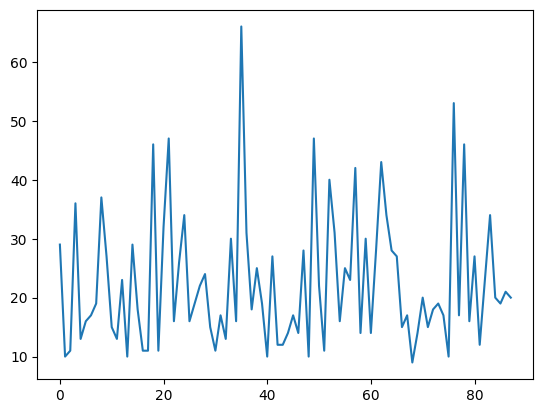

In [1]:
import matplotlib.pyplot as plt
import torch
import gymnasium
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
import numpy as np
import random

env = Monitor(gymnasium.make("CartPole-v1"))
model = DQN("MlpPolicy", env, verbose=0)
seeds = [1, 2]
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)
    env.reset(seed= seed)
    env.action_space.seed(seed)
    torch.manual_seed(seed)
    model.set_random_seed(seed)
    rng = np.random.default_rng(seed)
    env.unwrapped.np_random = rng
    model.learn(total_timesteps=int(1e3))
train_rewards = np.array(env.get_episode_rewards())

plt.plot(train_rewards)
plt.show()

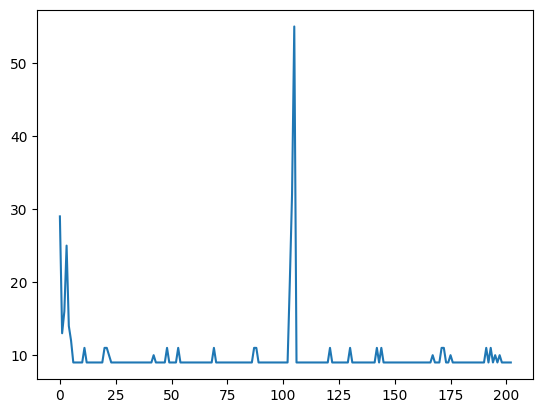

In [10]:
import matplotlib.pyplot as plt
train_rewards = np.array(env.get_episode_rewards())
plt.plot(train_rewards)
plt.show()

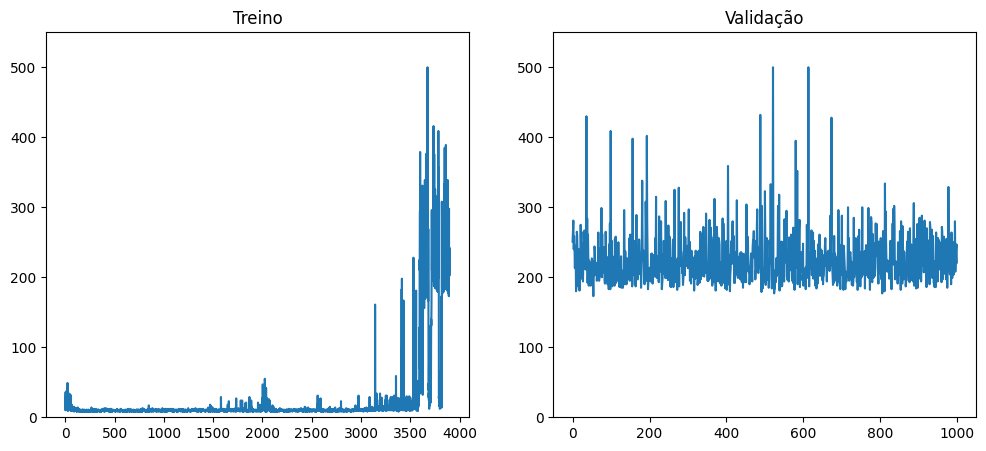

In [2]:
import matplotlib.pyplot as plt
import numpy as np

train_rewards = np.array(env.get_episode_rewards())
eval_rewards = np.array(eval_env.get_episode_rewards())

figs, axs = plt.subplots(1,2, figsize=(12, 5))
axs[0].plot(train_rewards)
axs[0].set_ylim(0, 550)
axs[0].set_title('Treino')

axs[1].plot(eval_rewards)
axs[1].set_ylim(0, 550)
axs[1].set_title('Validação')

plt.show()

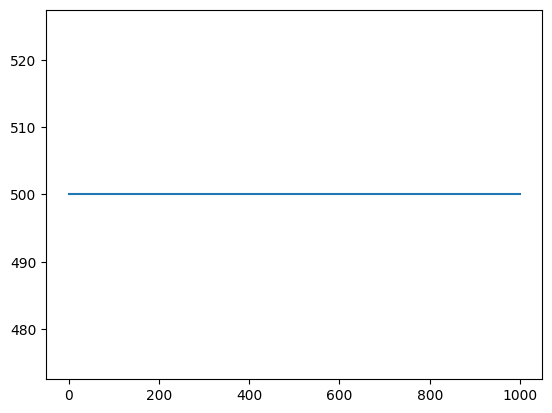

In [3]:
from stable_baselines3.dqn import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import matplotlib.pyplot as plt
import gymnasium

model = DQN.load('dqn_funcional')
env = Monitor(gymnasium.make('CartPole-v1'))
mean, _ = evaluate_policy(model, env, n_eval_episodes=int(1e3), return_episode_rewards = True)

plt.plot(mean)
plt.show()

In [4]:
teste(model)

In [ ]:
import gymnasium as gym

from stable_baselines3 import DQN

env = gym.make("CartPole-v1", render_mode="human")

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)
#model.save("dqn_cartpole")
teste(model)